In [1]:
import numpy as np
import cv2
import os

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.image as mpimg
from skimage.feature import hog
from scipy.ndimage.measurements import label
from sklearn.preprocessing import StandardScaler
import glob
from sklearn.svm import LinearSVC

from skimage.io import imread
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

#from svc_train import build_svc_model
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import time
import pickle

from utils_vehicles import showImageList

%matplotlib inline


In [3]:
def bin_spatial(img, size=(32, 32)):
    # Create the feature vector
    features = cv2.resize(img, size).ravel() 
    return features

# Compute color histogram features  
#def color_hist(img, nbins=32, bins_range=(0, 1)):
def color_hist(img, nbins=32, bins_range=(0, 256)):
    
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features


# Extract features from a list of images using bin_spatial(), color_hist() and get_hog_features()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

In [4]:
cars = glob.glob('./sample_data/vehicles/**/*.png')
notcars = glob.glob('./sample_data/non-vehicles/**/*.png')
test_images = sorted(glob.glob('./test_images/*.jpg'))

In [5]:
# Define HOG parameters
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 128   # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [365, 656] # Min and max in y to search in slide_window()

# hog_channel = ALL --> 6444 bytes 

In [6]:
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

/Users/donchan/anaconda3/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [7]:
print(np.array( car_features).shape, np.array(notcar_features).shape)

(8792, 6444) (8968, 6444)


In [8]:
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

In [9]:
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

In [10]:
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

21.37 Seconds to train SVC...
Test Accuracy of SVC =  0.9842


In [11]:
# implement C parameter of SVC 
Cs = np.logspace(-6, -1, 10)

In [12]:
t=time.time()
clf = GridSearchCV(estimator=svc, param_grid=dict(C=Cs))
clf.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train grid searched implemented SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(clf.score(X_test, y_test), 4))

153.13 Seconds to train grid searched implemented SVC...
Test Accuracy of SVC =  0.9862


In [13]:
clf.best_estimator_
#clf.best_score_


LinearSVC(C=0.00016681005372000591, class_weight=None, dual=True,
     fit_intercept=True, intercept_scaling=1, loss='squared_hinge',
     max_iter=1000, multi_class='ovr', penalty='l2', random_state=None,
     tol=0.0001, verbose=0)

In [14]:
svc = LinearSVC(C=0.00016681005372000591)
svc.fit(X_train, y_train)

LinearSVC(C=0.0001668100537200059, class_weight=None, dual=True,
     fit_intercept=True, intercept_scaling=1, loss='squared_hinge',
     max_iter=1000, multi_class='ovr', penalty='l2', random_state=None,
     tol=0.0001, verbose=0)

In [15]:
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

Test Accuracy of SVC =  0.9862


In [16]:
obj = {
        "svc": svc,
        "scaler": X_scaler,
        "orient" : orient,
        "pix_per_cell": pix_per_cell,
        "cell_per_block": cell_per_block,
        "spatial_size": spatial_size,
        "hist_bins": hist_bins       
    }
pickle.dump(obj, open('svc_pickle.p', 'wb'))

In [17]:
print(" save X / y train test data ....")
np.save("X_train.npy", X_train  )
np.save("X_test.npy", X_test  )
np.save("y_train.npy", y_train  )
np.save("y_test.npy", y_test  )

 save X / y train test data ....


In [21]:
x = np.ones((1,6444))
y_train[:10]

array([ 1.,  1.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,  0.])

In [22]:
svc.predict(X_train[:10])

array([ 1.,  1.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,  0.])

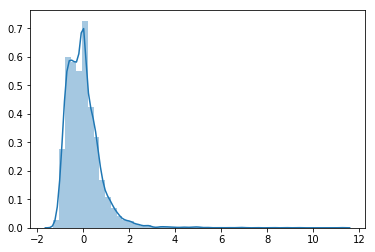

In [26]:
import seaborn as sns
sns.distplot(X_train[2])

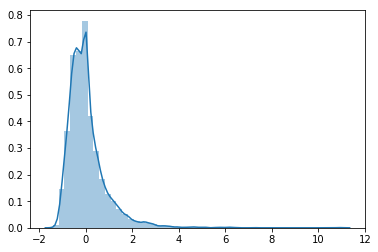

In [27]:
import seaborn as sns
sns.distplot(X_train[0])

## reference : Random Forest 

In [31]:
rf_1 = RandomForestClassifier(n_estimators=50, min_samples_split=7, min_samples_leaf=1)

## check the training time for the RF
t=time.time()
rf_1.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'seconds to train RF')

## check the score of the RF
print('Test Accuracy of RF = ', round(rf_1.score(X_test, y_test), 4))

55.41 seconds to train RF
Test Accuracy of RF =  0.9938


In [32]:
from sklearn.model_selection import RandomizedSearchCV
from time import time
from scipy.stats import randint as sp_randint

# build a classifier
clf = RandomForestClassifier(n_estimators=50)

In [33]:
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


In [35]:
# specify parameters and distributions to sample from
param_dist = {"max_depth": [3, None],
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(2, 11),
              "min_samples_leaf": sp_randint(1, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run randomized search
n_iter_search = 50
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search)

start = time()
random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)

RandomizedSearchCV took 464.34 seconds for 50 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.990 (std: 0.002)
Parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 10, 'min_samples_leaf': 2, 'min_samples_split': 7}

Model with rank: 2
Mean validation score: 0.990 (std: 0.002)
Parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'max_features': 9, 'min_samples_leaf': 3, 'min_samples_split': 4}

Model with rank: 3
Mean validation score: 0.990 (std: 0.002)
Parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'max_features': 10, 'min_samples_leaf': 8, 'min_samples_split': 6}

Model with rank: 3
Mean validation score: 0.990 (std: 0.002)
Parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}



In [38]:
obj = {
        "rf": rf_1,
        "scaler": X_scaler,
        "orient" : orient,
        "pix_per_cell": pix_per_cell,
        "cell_per_block": cell_per_block,
        "spatial_size": spatial_size,
        "hist_bins": hist_bins       
    }
pickle.dump(obj, open('rf_pickle.p', 'wb'))

In [36]:
random_search.best_estimator_

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=None, max_features=10, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=7,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [37]:
random_search.best_score_

0.99035754504504503